## 2-D Poisson equation solution for electrostatics using PINN

We find solution to the Poisson equation with Dirichlet boundary conditions using physically informed neural networks (PINN).
\begin{equation}
\nabla^2\phi=\frac{\partial^2 \phi}{\partial x^2} + \frac{\partial^2 \phi}{\partial y^2}=0
\end{equation}

We will implement using pure tensorflow/keras.

In [1]:
import tensorflow as tf
import tensorflow.keras as tfk
import matplotlib.pyplot as plt
import numpy as np
from diffutils import *
from gtree import *
import pickle
from apinn import *

In [2]:
def fxy(t):
    x = t[:, 0]
    y = t[:, 1]
    return x*x + y*y*y

In [3]:
x= np.array([[2.0]], dtype=np.float32)
y= np.array([[5.0]], dtype=np.float32)
print(Laplacian(fxy, x, y))

tf.Tensor([[32.]], shape=(1, 1), dtype=float32)


### Geometry class

In [4]:
a = geom_rect(0.0, 0.0, 2.0, 1.0)
b = geom_circ(0.0, 0.0, 0.3)
c = geom_rect(0.7, 0.1, 0.3, 0.3)
combined = GTree.AND(a, GTree.AND(GTree.NOT(b), GTree.NOT(c)))

In [5]:
print(combined)

(rect(0.0, 0.0, 2.0, 1.0) AND ( (~circ(0.0, 0.0, 0.3))  AND  (~rect(0.7, 0.1, 0.3, 0.3)) ))


In [6]:
points = np.array([[0.0, 0.0], [0.0, 0.5], [0.5, 0.0]])
print(a.is_inside(points))
print(b.is_inside(points))
print(combined.is_inside(points))

[ True False  True]
[ True False False]
[False False  True]


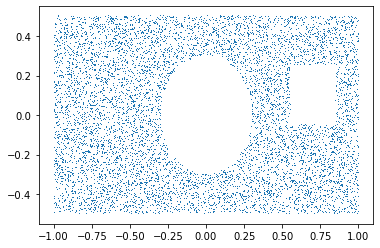

In [7]:
interiorpoints = combined.generate_points(10000)
plt.plot(interiorpoints[:,0], interiorpoints[:,1], ',')

### Disc in a square wall
Disc of radius 1 in a square box of size 2. 
$\phi_{disc}=1$ and $\phi_{box}=-1$.

In [8]:
ap= APINN()
disc_boundary = b.generate_points(1000)
disc_pot = np.expand_dims(np.array([-1.0]*1000, dtype=np.float32), axis=1)
ap.add_Dirichlet_BC(disc_boundary, disc_pot)
rect_boundary = a.generate_points(500)
rect_pot = np.expand_dims(np.array([1.0]*2000, dtype=np.float32), axis=1)
ap.add_Dirichlet_BC(rect_boundary, rect_pot)

rect_boundary2 = c.generate_points(500)
rect_pot2 = np.expand_dims(np.array([0.0]*2000, dtype=np.float32), axis=1)
ap.add_Dirichlet_BC(rect_boundary2, rect_pot2)

In [9]:
interiorpoints = combined.generate_points(10000)
ap.add_interior_points(interiorpoints)

In [10]:
ap.initialize()

In [11]:
ap.learning_rate =1e-2
ap.optimizer = tf.optimizers.Adam(1e-2)
ap.lamoptimizer = tf.optimizers.Adam(1e-2)

In [12]:
ap.buildNN()
#ap.load()

In [36]:
#ap.train(1000, -1, trainforBC=True)
ap.train(50000, -1, trainforBC=False)

0: 0.006714918650686741
10: 0.007744953036308289
20: 0.012548170983791351
30: 0.011814284138381481
40: 0.007266769651323557
50: 0.006920798681676388
60: 0.00808173418045044
70: 0.015758851543068886
80: 0.010403802618384361
90: 0.008598241955041885
100: 0.008140345104038715
110: 0.007419096305966377
120: 0.010235179215669632
130: 0.006971719209104776
140: 0.00654701329767704
150: 0.007796663325279951
160: 0.016887739300727844
170: 0.008821597322821617
180: 0.007937800139188766
190: 0.006781250238418579
200: 0.00639402586966753
210: 0.006405056454241276
220: 0.009269430302083492
230: 0.01971529982984066
240: 0.00987086072564125
250: 0.007436108775436878
260: 0.0072362395003438
270: 0.0073779490776360035
280: 0.007066500373184681
290: 0.006853195838630199
300: 0.00871039554476738
310: 0.008267202414572239
320: 0.007391553372144699
330: 0.012554358690977097
340: 0.009186703711748123
350: 0.006939693354070187
360: 0.008001849986612797
370: 0.008436690084636211
380: 0.009241485968232155
390:

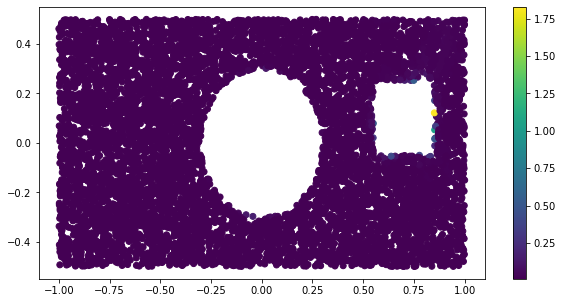

In [37]:
%matplotlib inline
phiin =weightfn2(ap.interiorlam)
#phiin = ap.lamint(ap.interiorpoints)
plt.figure(figsize=(10,5))
plt.scatter(ap.interiorpoints[:,0], ap.interiorpoints[:,1], c=phiin[:,0])
plt.colorbar()

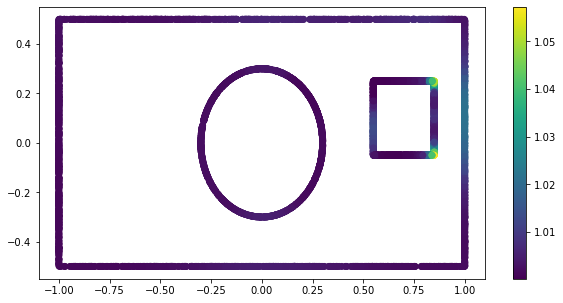

In [38]:
%matplotlib inline
phibc = weightfn2(ap.BClam)
#phibc = ap.lamBC(ap.BCpoints)
plt.figure(figsize=(10,5))
plt.scatter(ap.BCpoints_x, ap.BCpoints_y, c=phibc[:,0])
plt.colorbar()

In [39]:
ngrid=50
grid2d =  np.mgrid[-1.0:1.0:ngrid*1j,-0.5:0.5:ngrid*1j].astype(np.float32)
X, Y = grid2d
XY = np.hstack((X.reshape(ngrid**2,1), Y.reshape(ngrid**2,1)))
Z = ap.phi_xy(XY)

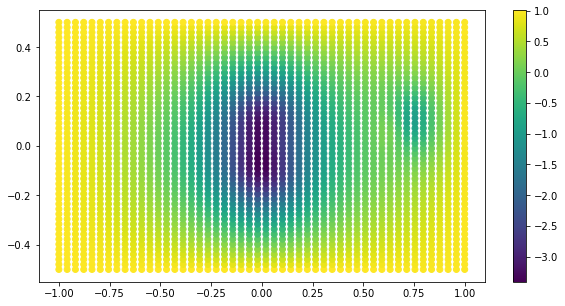

In [40]:
%matplotlib inline
plt.figure(figsize=(10,5))
plt.scatter(XY[:, 0], XY[:, 1], c=Z[:,0])
plt.colorbar()

<a list of 30 text.Text objects>

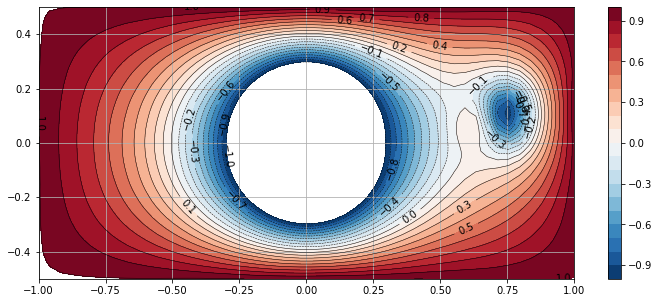

In [41]:
%matplotlib inline
plt.figure(figsize=(12,5))

plt.contourf(X, Y, Z.numpy().reshape((50,50)), np.linspace(-1, 1.0, 21), vmin=-1.0, vmax=1.0, cmap='RdBu_r')
plt.colorbar()
plt.gca().grid()
C = plt.contour(X, Y, Z.numpy().reshape((50,50)), np.linspace(-1, 1.0, 21), vmin=-1.0, vmax=1.0 , colors='black',  linewidths=0.5)
plt.clabel(C, inline=1, fontsize=10)

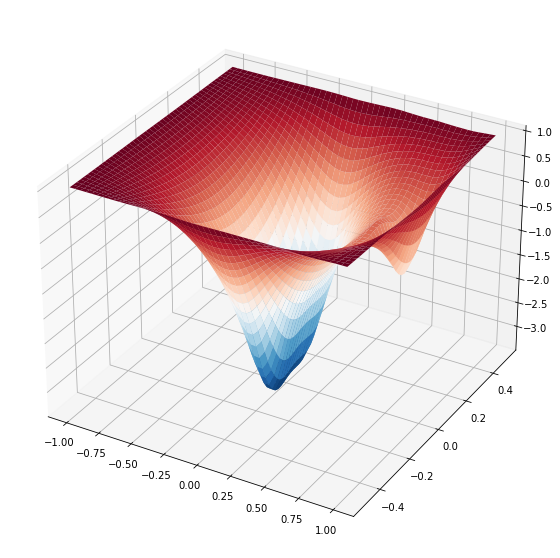

In [42]:
%matplotlib inline
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z.numpy().reshape((50,50)), 10, colors='black',)
ax.plot_surface(X, Y, Z.numpy().reshape((50,50)), cmap='RdBu_r', edgecolor=None )

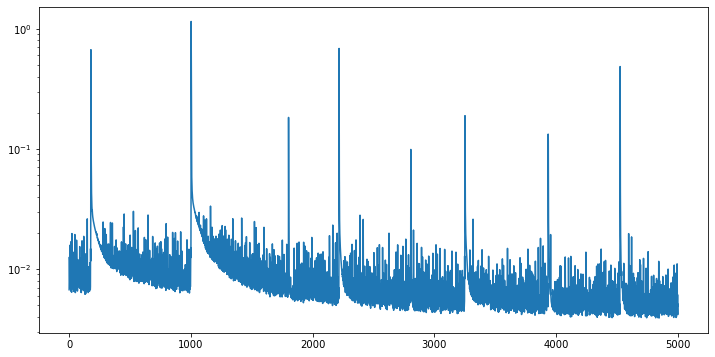

In [43]:
%matplotlib inline
plt.figure(figsize=(12,6))
ax = plt.gca()
ax.set_yscale('log')
plt.plot(np.arange(len(ap.train_hist)), np.array(ap.train_hist))

In [44]:
ap.save()

INFO:tensorflow:Assets written to: poisson_pinn/phi_xy\assets
INFO:tensorflow:Assets written to: poisson_pinn/lamBC\assets
INFO:tensorflow:Assets written to: poisson_pinn/lamint\assets
